# Project 1
## Wolesale
### 1. load data
we load the data from a csv and then do something

In [1]:
%matplotlib inline
import numpy as np
import scipy,scipy.spatial
import torch
import torchvision,torchvision.transforms
import sqlite3
import matplotlib
from matplotlib import pyplot as plt

raw_data = np.genfromtxt("Wholesale customers data.csv", skip_header=1, delimiter=",")


In [33]:
# we are not interested in the region 
_data_no_log = np.delete(raw_data, (1), axis=1) 
_data_log = _data_no_log.copy()
_data_log[:, 1:] = np.log10(1 + _data_log[:, 1:])
data = _data_log # set to data_log instead for compressed data

# seperating by channel
is_horeca = (data[:, 0]-1) == 0
data_horeca = data[is_horeca, 1:]
data_retail = data[~is_horeca, 1:]

# total spending in the catagories
totals = np.sum(data[:, 1:], axis=1)

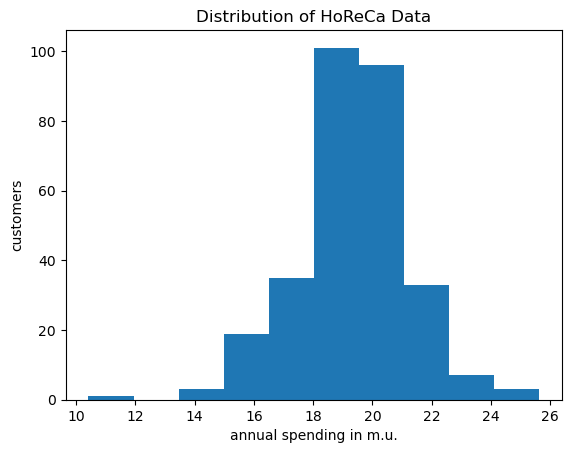

In [34]:
# we want to visualize the data to get a general overview
# we want to visualize the data to get a general overview
def graph_histogram(data, bin_count:int, name:str):

    _, ax = plt.subplots()
    plt.hist(data, bins=bin_count)

    #plt.xscale('log')
    ax.set_title(f'Distribution of {name} Data')
    ax.set_xlabel('annual spending in m.u.')
    ax.set_ylabel('customers')

horeca_totals = np.sum(data_horeca, axis=1)
graph_histogram(horeca_totals, 10, "HoReCa")
plt.show()

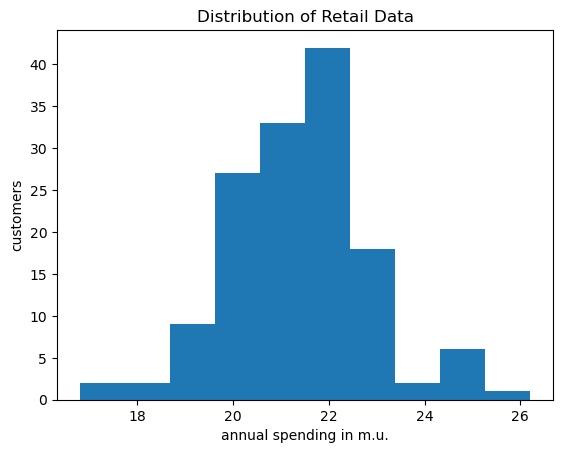

In [35]:
# we want to visualize the data to get a general overview

retail_totals = np.sum(data_retail, axis=1)
graph_histogram(retail_totals, 10, "Retail")
plt.show()

In [7]:
data.shape

(440, 7)

Clustering (k-means): lets start with k=10 and then look at the data to see if another value would fit better

In [28]:
# clustering 

from scipy.cluster.vq import kmeans, vq
from scipy.spatial.distance import cdist

K = range(1,20)

clust = [kmeans(data[:,1::],k) for k in K] # cluster only on spending data
    
centroids = [cent for (cent,var) in clust]
D_k = [cdist(data[:,1::], cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/data.shape[0] for d in dist]



Text(0.5, 1.0, 'Elbow for KMeans clustering')

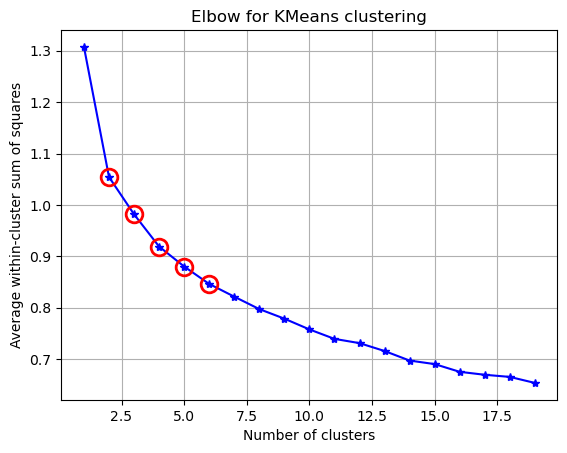

In [29]:
kIdx = [1, 2, 3, 4, 5]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
for d in kIdx:
    ax.plot(K[d], avgWithinSS[d], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

So probably around 3 clusters or so

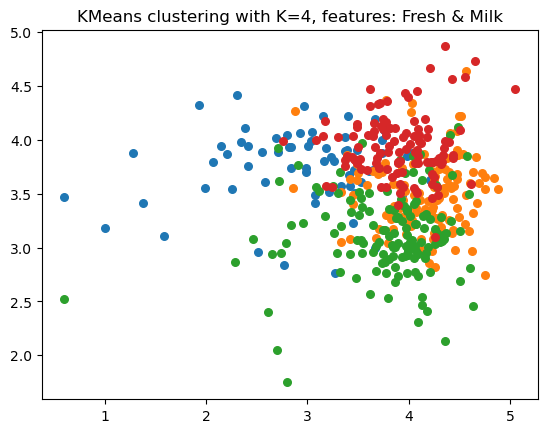

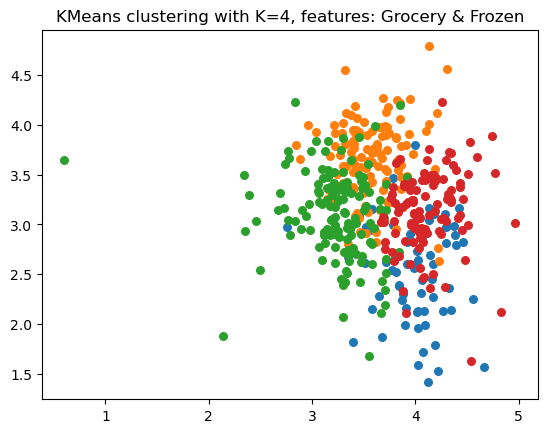

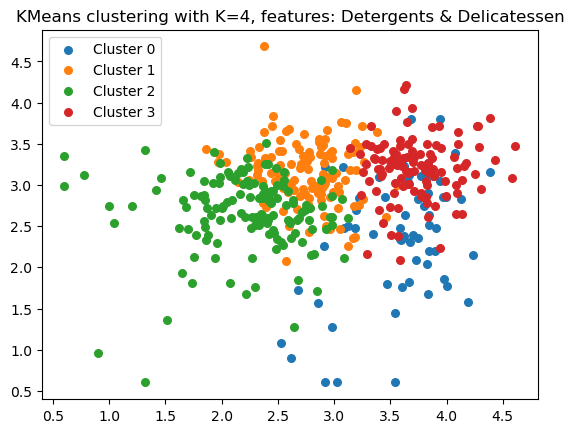

In [30]:
kIdx = 3  # equals 4 clusters

# scatter plot

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(data[ind,1],data[ind,2], s=30, label='Cluster %d'%i)
    #ax.plot(centroids[kIdx+1][i,1], centroids[kIdx+1][i,2], marker='o', markersize=12, markeredgewidth=2)
plt.title('KMeans clustering with K=%d, features: Fresh & Milk' % K[kIdx])

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(data[ind,3],data[ind,4], s=30, label='Cluster %d'%i)
    #ax.plot(centroids[kIdx+1][i,3], centroids[kIdx+1][i,4], marker='o', markersize=12, markeredgewidth=2)
plt.title('KMeans clustering with K=%d, features: Grocery & Frozen' % K[kIdx])

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(data[ind,5],data[ind,6], s=30, label='Cluster %d'%i)
    #ax.plot(centroids[kIdx+1][i,5], centroids[kIdx+1][i,6], marker='o', markersize=12, markeredgewidth=2)
plt.title('KMeans clustering with K=%d, features: Detergents & Delicatessen' % K[kIdx])

plt.legend()

plt.show()


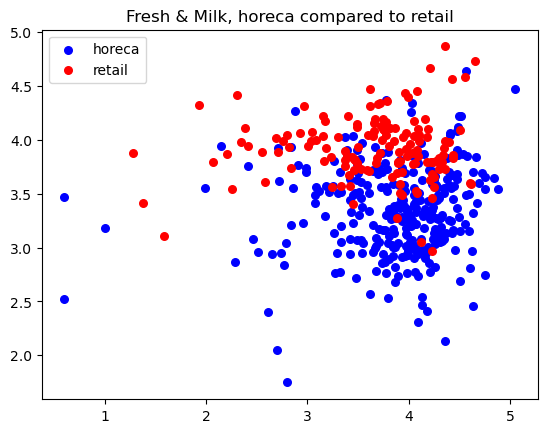

In [31]:
# now lets colour the dots according to the horeca-ness

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])

ax.scatter(data[np.argwhere(data[:,0]==1),1],data[np.argwhere(data[:,0]==1),2], s=30, c='b', label='horeca')

ax.scatter(data[np.argwhere(data[:,0]==2),1],data[np.argwhere(data[:,0]==2),2], s=30, c='r', label='retail')

    #ax.plot(centroids[kIdx+1][i,1], centroids[kIdx+1][i,2], marker='o', markersize=12, markeredgewidth=2)
plt.title('Fresh & Milk, horeca compared to retail')

plt.legend()

plt.show()

so cluster 0 and 1 seem to correspond to horecas, whereas clusters 2 and 3 seem to be made of retail (green seems to be a bigger kind of store whereas yellow might correspond to the portugal-equivalent of spätis)

In [36]:
# now lets see how that works out in fewer dimensions

from sklearn.manifold import TSNE

data_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(data[:,1::]) 
#also only on spending data of course

In [37]:
data_embedded.shape

(440, 2)

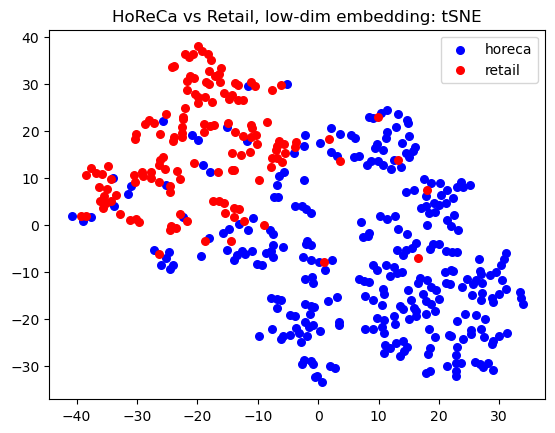

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(data_embedded[np.argwhere(data[:,0]==1),0],data_embedded[np.argwhere(data[:,0]==1),1], s=30, c='b', label='horeca')
ax.scatter(data_embedded[np.argwhere(data[:,0]==2),0],data_embedded[np.argwhere(data[:,0]==2),1], s=30, c='r', label='retail')

plt.title('HoReCa vs Retail, low-dim embedding: tSNE')

plt.legend()

plt.show()

Nice, there seems to bee some kind of natural differnce between the two.

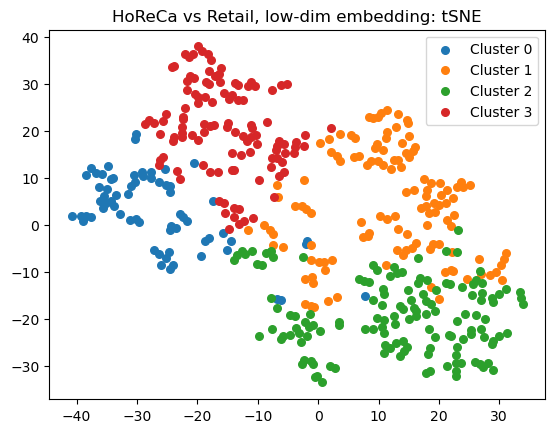

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(data_embedded[ind,0],data_embedded[ind,1], s=30, label='Cluster %d'%i)
    #ax.plot(centroids[kIdx+1][i,5], centroids[kIdx+1][i,6], marker='o', markersize=12, markeredgewidth=2)

plt.title('HoReCa vs Retail, low-dim embedding: tSNE')

plt.legend()

plt.show()


doesnt that look nice?